# Projeto 1 - Ciência dos Dados

Nome: Rafael Meyer Kahn<br>
Nome: Hélio Zaia Franciscon

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tweepy
import math
import pandas as pd
import json
from random import shuffle
import emoji_list
import emoji
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\lobda\Desktop\Insper\2º Semestre\Ciência dos Dados\DP\Projeto-1


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
dados = pd.read_excel('Netflix.xlsx')
teste = pd.read_excel('Netflix.xlsx', 'Teste')

___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O produto abordado durante este projeto foi Netflix. Por ser uma provedora global de filmes e séries, existem diversos tweets sobre seu conteúdo, portanto foi levado em consideração 4 níveis de classificação: Irrelevante, Elogio, Crítica e Sugestão. Com isso, pode-se classificar os tweets obtidos nessas 4 categorias para melhor organizar o tipo de comentário que estão fazendo sobre o produto na internet, resultando assim numa melhor distribuição dos tweets para cada área da empresa analisar os fatores relevantes que estão sendo tweetados on-line.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [4]:
#Exibindo tweets
dados.head(10)

,Treinamento,Classificacao
0,"achei uma série de investigação policial, agor...",1
1,uma sequência do clássico está programada para...,0
2,#alteredcarbon animação da netflix ganha trail...,0
3,"sofá, breja e netflix \nsó na cama vários hits",1
4,o surto que confundi e corri na netflix achand...,0
5,troco em dobro (2020) | nada mais do que puro ...,0
6,netflix não conte comigo para mais nada eu me ...,0
7,rt @hgirardi98: netflix favor parar de lançar ...,2
8,rt @solteirasince: meu hobby é ficar duas hora...,0
9,nao são nem 9h da manhã e já to querendo ir pr...,0


In [5]:
#Definindo uma função que limpa caractéres indesejados
def clean(tabela, titulo):
    a = tabela[titulo]
    a = a.str.lower()

    itens = ['.', ':', ';', '"', "'", '?', '(', ')', '[',']',',', '\n', '\t','*','|','+']
    i2 = ['?', '!']
    emojis = emoji_list.all_emoji
    #separa emojis de palavras
    for emoji in emojis:
        try:
            a = a.str.replace(emoji," {} ".format(emoji) )
        except:
            pass
    #retira caracteres indesejados
    for e in itens:
        a = a.str.replace(e,'')
    #separa '?' e '!' de palavras
    for e in i2:
        a = a.str.replace(e,' {} '.format(e))

    #Substitui caracteres com acento ou variação por caracteres desejados
    a = a.str.replace('é','e')
    a = a.str.replace('ê','e')
    a = a.str.replace('á','a')
    a = a.str.replace('ã','a')
    a = a.str.replace('ô','o')
    a = a.str.replace('ó','o')
    a = a.str.replace('ú','u')
    a = a.str.replace('ç','c')
    a = a.str.replace('í','i')
    a = a.str.replace('@',' @')
        
    tabela[titulo] = a

    return tabela

In [6]:
#Limpando os dados
filtro = clean(dados, 'Treinamento')
#Testando
filtro.head(10)

,Treinamento,Classificacao
0,achei uma serie de investigacao policial agora...,1
1,uma sequencia do classico esta programada para...,0
2,# alteredcarbon animacao da netflix ganha tra...,0
3,sofa breja e netflix so na cama varios hits,1
4,o surto que confundi e corri na netflix achand...,0
5,troco em dobro 2 0 2 0 nada mais do que ...,0
6,netflix nao conte comigo para mais nada eu me ...,0
7,rt @hgirardi 9 8 netflix favor parar de lan...,2
8,rt @solteirasince meu hobby e ficar duas hora...,0
9,nao sao nem 9 h da manha e ja to querendo ir ...,0


In [7]:
#Separando em tabelas por classificação
irrelevante = filtro.loc[(filtro.Classificacao == 0)]
elogio = filtro.loc[(filtro.Classificacao == 1)]
critica = filtro.loc[(filtro.Classificacao == 2)]
sugestao = filtro.loc[(filtro.Classificacao == 3)]

In [8]:
#Definindo uma função que separa as palavras
def tt_split(tabela, titulo):
    a = tabela[titulo].str.split(' ')

    li = pd.DataFrame()
    li['palavras'] = []

    for lista in a:
        for e in ['#','' , ' ']:
            while lista.count(e) != 0:
                lista.remove(e)

        for palavra in lista:
            if '@' in palavra and palavra != '@':
                lista.remove(palavra) 
            if palavra[:4] == 'http':
                lista.remove(palavra)
        li = li.append({'palavras': lista}, ignore_index=True)
                
    return li

In [9]:
#Separando os tweets das tabelas limpas
irrelevante_limpa = tt_split(irrelevante, 'Treinamento')
elogio_limpa = tt_split(elogio, 'Treinamento')
critica_limpa = tt_split(critica, 'Treinamento')
sugestao_limpa = tt_split(sugestao, 'Treinamento')
todos_limpa = tt_split(filtro, 'Treinamento')
#Testando
elogio_limpa.head(10)

,palavras
0,"[achei, uma, serie, de, investigacao, policial..."
1,"[sofa, breja, e, netflix, so, na, cama, varios..."
2,"[estou, assistindo, uma, serie, mt, boa, sobre..."
3,"[rt, a, historia, do, lil, peep, e, incrivel, ..."
4,"[acabei, de, assistir, a, animacao, de, pokemo..."
5,"[rt, melhor, date, do, mundo, e, em, casa, dei..."
6,"[almocar, a, ver, um, filme, random, da, netfl..."
7,"[meu, deus, agora, que, eu, vi, que, tem, itae..."
8,"[e, a, netflix, que, vai, lancar, uma, serie, ..."
9,"[a, netflix, ate, que, tem, um, acervo, bom, d..."


In [10]:
#Definindo função que cria tabela com as palavras separadas
def palavras(tabela):
    a = tabela['palavras']
    prob = pd.DataFrame()
    prob['palavras'] = []
    for lista in a:
        for e in lista:
            prob = prob.append({'palavras': e}, ignore_index=True)
    
    return prob['palavras']

In [11]:
#Separando as palavras
irrelevante_separada = palavras(irrelevante_limpa)
elogio_separada = palavras(elogio_limpa)
critica_separada = palavras(critica_limpa)
sugestao_separada = palavras(sugestao_limpa)
todos_separada = palavras(todos_limpa)
#Testando
elogio_separada.head(10)

0           achei
1             uma
2           serie
3              de
4    investigacao
5        policial
6           agora
7              eu
8           nunca
9            mais
Name: palavras, dtype: object

In [12]:
#Obtendo as frequências absolutas
freq_irrelevante = irrelevante_separada.value_counts()
freq_elogio = elogio_separada.value_counts()
freq_critica = critica_separada.value_counts()
freq_sugestao = sugestao_separada.value_counts()
freq_todos = todos_separada.value_counts()
#Testando
freq_elogio.head(10)

netflix    111
e           78
a           58
de          52
que         50
na          46
eu          36
um          28
o           28
serie       25
Name: palavras, dtype: int64

In [13]:
#Obtendo as frequências relativas
freq_rel_irrelevante = irrelevante_separada.value_counts(True)
freq_rel_elogio = elogio_separada.value_counts(True)
freq_rel_critica = critica_separada.value_counts(True)
freq_rel_sugestao = sugestao_separada.value_counts(True)
freq_rel_todos = todos_separada.value_counts(True)
#Testando
freq_rel_elogio.head(10)

netflix    0.055005
e          0.038652
a          0.028741
de         0.025768
que        0.024777
na         0.022795
eu         0.017839
um         0.013875
o          0.013875
serie      0.012389
Name: palavras, dtype: float64

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [14]:
teste['Bot'] = 0
teste['Resultado'] = pd.Series()
teste_clean = clean(teste,'Teste')
teste_f = tt_split(teste_clean,'Teste')

#função para multiplicar itens dentro de uma lista
def multiplica(Lista) :     
    u = 1
    for x in Lista: 
         u = u * x  
    return u  

In [15]:
teste_f.head()

,palavras
0,"[to, sem, netflix, que, triste, como, q, vou, ..."
1,"[e, vamos, de, netflix, maior, e, melhor]"
2,"[@kelcyrus, ja, pode, fechar, contrato, com, a..."
3,"[sim, tiraram, o, meu, dorama, favorito, da, n..."
4,"[rt, netflix, lanca, sua, primeira, serie, sul..."


In [16]:
i = 0
for lin in teste_f['palavras']:
    p0 = 1
    p1 = 1
    p2 = 1
    p3 = 1
    sim = 1
    nao = 0
    prob1 = []
    prob0 = []
    prob2 = []
    prob3 = []
    for palavra in lin:
        try:
            p0 *= (freq_irrelevante[palavra] +1)/(sum(freq_irrelevante) + len(freq_todos))
            prob0.append(p0)
        except:
            p0 *= 1/(sum(freq_irrelevante) + len(freq_todos))
            prob0.append(p0)
        try:
            p1 *= (freq_elogio[palavra] +1)/(sum(freq_elogio) + len(freq_todos))
            prob1.append(p1)
        except:
            p1 *= 1/(sum(freq_elogio) + len(freq_todos))
            prob1.append(p1)
        try:
            p2 *= (freq_critica[palavra] +1)/(sum(freq_critica) + len(freq_todos))
            prob2.append(p2)
        except:
            p2 *= 1/(sum(freq_critica) + len(freq_todos))
            prob2.append(p2)
        try:
            p3 *= (freq_sugestao[palavra] +1)/(sum(freq_sugestao) + len(freq_todos))
            prob3.append(p3)
        except:
            p3 *= 1/(sum(freq_sugestao) + len(freq_todos))
            prob3.append(p3)
            
    multiplica0 = multiplica(prob0)*(sum(freq_irrelevante)/sum(freq_todos))   
    multiplica1 = multiplica(prob1)*(sum(freq_elogio)/sum(freq_todos))
    multiplica2 = multiplica(prob2)*(sum(freq_critica)/sum(freq_todos))   
    multiplica3 = multiplica(prob3)*(sum(freq_sugestao)/sum(freq_todos))
    
    
    
    if (multiplica0>multiplica1) & (multiplica0 > multiplica2) & (multiplica0 > multiplica3):
        teste['Bot'][i] = 0
        if teste['Bot'][i] == teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Positivo Verdadeiro'
        elif teste['Bot'][i] != teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Positivo Falso'
    elif (multiplica1>multiplica0) & (multiplica1 > multiplica2) & (multiplica1 > multiplica3):
        teste['Bot'][i] = 1
        if teste['Bot'][i] == teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Verdadeiro'
        elif teste['Bot'][i] != teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Falso'
    elif (multiplica2>multiplica0) & (multiplica2 > multiplica1) & (multiplica2 > multiplica3):
        teste['Bot'][i] = 2
        if teste['Bot'][i] == teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Verdadeiro'
        elif teste['Bot'][i] != teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Falso'
    else:
        teste['Bot'][i] = 3
        if teste['Bot'][i] == teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Verdadeiro'
        elif teste['Bot'][i] != teste['Classificacao'][i]:
            teste['Resultado'][i] = 'Negativo Falso'
    
    i += 1

C:\Users\lobda\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lobda\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lobda\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\lobda\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value i

In [17]:
matrix = pd.crosstab(teste['Classificacao'], teste['Bot'], normalize = True)
matrix

Bot,0,1,2,3
Classificacao,,,,
0,0.1775,0.0400,0.040,0.3125
1,0.0300,0.0225,0.020,0.1025
2,0.0375,0.0150,0.025,0.1125
3,0.0125,0.0050,0.005,0.0425


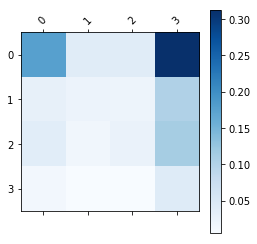

In [18]:
#Criando função para plotar o gráfico
def plot_confusion_matrix(df_confusion, cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)

#Plotando o gráfico    
plot_confusion_matrix(matrix)

___
### Concluindo

O calssificador apresentou baixa precisão ao classificar os tweets devido à sua base de treino, esse fato deve-se à forma como os tweets sobre o título escolhido, Netflix, são compostos.

Grande parte dos tweets em nosso DataFrame possuem mais de uma forma de serem classificados, e muitas vezes não se adequam perfeitamente às classificações propostas, dessa forma ao treinar o algorítimo para aprender a classifica-los ocorre uma alteração em como o classificador contabiliza as frases devido as palavras presentes nesses tweets que acabam sendo levados em conta na hora de classificar um tweet qualquer, ou seja, no momento em que nosso algoritimo classifica um tweet ele leva em conta o numero total de palavras e a chance de ocorrencia de cada uma delas em uma frase, assim levando em conta também as palavras presentes nesses tweets ambiguos, o que favorece uma classificação menos precisa do tweet sendo analisado.

Como a base de tweets a ser classificado é grande, assim como o numero de tweets ambiguos, acaba ocorrendo uma série de classificações erradas, o que acaba por deixar o algoritimo pouco preciso.

### Proposta de melhora
___

Tendo em vista os motivos pelos quais o nosso algoritimo apresentou uma precisão abaixo da desejada: problemas com tweets ambiguos e de duvidosa classificação. Uma forma de melhorar a precisão seria: Revisar o DataFrame "Treinamento" com o qual nosso classificador "Aprende" a classificar os tweets, de modo a deixa-lo o mais limpo de tweets ambiguos quanto possível. 

Para fazer isso teriamos que revisar o DataFrame "Treinamento" em busca dos tweets em que houveram dificuldades de classificação, e substitui-los por tweets mais coerentes que não deixassem qualquer duvida sobre como proderiam ser classificados, ou seja, uma classificação absoluta. Dessa forma ao contabilizar as palavras presentes nesse novos tweets (e ao mesmo tempo deixando de levar em conta as palavras presentes nos tweets ambiguos) teriamos uma classificação mais precisa, pois as palavras estariam com suas probabilidades de ocorrencia em um tweet qualquer sobre o titulo escolhido (Netflix) mais exatas, resultando em um algoritimo que melhor classificaria os tweets do DataFrame "Teste"

Além disso, outra melhoria importante no classificador seria obter uma base de dados classificada de forma mais homogênea, ou seja, obter uma base de treinamento com algo entorno de 25% dos tweets classificados para cada categoria, já que isso faria com que as probabilidades de cada categoria fossem mais corretas.


### Usos fora do contexto do projeto
___

Além de classificação de sentimentos, como abordado durante este projeto, o método de Naïve Bayes pode ser usados em diversos outros contextos, como por exemplo o sistema de filtragem de e-mails. Ele pode ser usado para classificar um e-mail como SPAM ou lixo eletrônico para assim deixar a caixa de e-mail dos usuários mais limpas e sem itens indesejados.


___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que periodicamente realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

https://www.datageeks.com.br/naive-bayes/